This is Part 1 of my AST 390 Final Porject. In this part, I use REBOUND to test if two Jupiter-Massed protoplanets will collide given semi-major axis and eccentricity parameters. I also implement a function that determines when (in years) and what true anomaly said collision occurs.

In [1]:
import rebound
import matplotlib.pyplot as plt
import numpy as np

We define a close encounter to be that in which either protoplanet is within the Hill sphere radius of the other. The Hill sphere radius is defined as:
$$r_{H} \approx a(1-e) \sqrt{\frac{m_{p}}{3M_{*}}}$$
where $m_{p}$ is the protoplanetary mass, and $M_{*}$ is the central star mass.


In [2]:
mass = 0.000954588 #Jupiter Mass in Solar Mass units
s1 = float(input('Enter semi-major axis in solar radius for the first protoplanet: ')) #Used value is 1.000 AU
s2 = float(input('Enter semi-major axis in solar radius for the second protoplanet: ')) #Used value is 1.006 AU
e1 = float(input('Enter eccentricity of the first protoplanet: ')) #Used value is 0.15
e2 = float(input('Enter eccentricity of the second protoplanet: ')) #Used value is 0.25

In [3]:
'''Set-Up Initial Conditions'''
def setupSimulation(mass,s1,s2,e1,e2):
    sim = rebound.Simulation()
    sim.integrator = 'ias15'
    sim.units = ('yr','AU','Msun')
    sim.add(m = 1.0)
    sim.add(m = mass, a= s1, e = e1, r = s1*(1-e1)*np.sqrt(mass/3))
    sim.add(m = mass, a= s2, e= e2,  r = s2*(1-e2)*np.sqrt(mass/3))
    sim.move_to_com()
    return sim

3 particles in the simulation at t = 0.0
Sun's Mass: 1.0 solar mass
Protoplanet 1 Mass: 0.000954588 solar mass
Protoplanet 2 Mass: 0.000954588 solar mass
Period of Protoplanet 1: 0.999541925022901 yr
Period of Protoplanet 2: 1.0080707100079123 yr
True Anomaly of Protoplanet 1: 0.0 radians
True Anomaly of Protoplanet 2: 0.0 radians


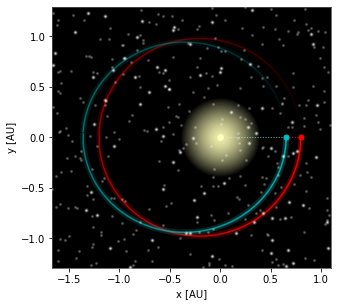

In [4]:
'''Conditions before collision'''
sim = setupSimulation(mass,s1,s2,e1,e2)
sim.collision = "direct"
sim.collision_resolve = "merge"

system_mass1 = np.array([i.m for i in sim.particles])
period1 = np.array([i.P for i in sim.calculate_orbits()])
trueanomaly1 = np.array([i.f for i in sim.calculate_orbits()])
p1 = period1[0]
p2 = period1[1]
f1 = trueanomaly1[0]
f2 = trueanomaly1[1]

print(f'{sim.N} particles in the simulation at t = {sim.t}')
print(f"Sun's Mass: {system_mass1[0]} solar mass")
print(f"Protoplanet 1 Mass: {system_mass1[1]} solar mass")
print(f"Protoplanet 2 Mass: {system_mass1[2]} solar mass")
print(f'Period of Protoplanet 1: {p1} yr')
print(f'Period of Protoplanet 2: {p2} yr')
print(f"True Anomaly of Protoplanet 1: {f1} radians")
print(f"True Anomaly of Protoplanet 2: {f2} radians")

fig = rebound.OrbitPlot(sim, unitlabel='[AU]', fancy=True, color=True, periastron=True)

2 particles in the simulation at t = 1.0080707100079123 yr
Sun's Mass: 1.0 solar mass
Collided Protoplanet Mass: 0.001909176 solar mass
Period of Collided Protoplanet: 0.9961240264420959 yr
True Anomaly of Collided Protoplanet: 0.11671171299501992 radians


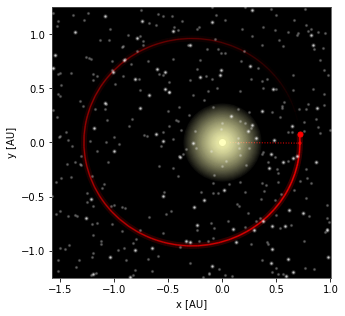

In [5]:
'''Conditions after collision'''
sim.integrate(p2) #Feel Free to edit this and use the period of Protoplanet 1

system_mass2 = np.array([i.m for i in sim.particles])
period2 = np.array([i.P for i in sim.calculate_orbits()])
trueanomaly2 = np.array([i.f for i in sim.calculate_orbits()])

print(f'{sim.N} particles in the simulation at t = {sim.t} yr')
if len(system_mass2) == 2:
    print(f"Sun's Mass: {system_mass2[0]} solar mass")
    print(f"Collided Protoplanet Mass: {system_mass2[1]} solar mass")
else:
    print(f"Sun's Mass: {system_mass2[0]} solar mass")
    print(f"Protoplanet 1 Mass: {system_mass2[1]} solar mass")   
    print(f"Protoplanet 2 Mass: {system_mass2[2]} solar mass")

if len(period2) == 1:
    print(f'Period of Collided Protoplanet: {period2[0]} yr')
else:
    print(f'Period of Protoplanet 1 (No Collision): {period2[0]} yr')
    print(f'Period of Protoplanet 2 (No Collision): {period2[1]} yr')

if len(trueanomaly2) == 1:
    print(f"True Anomaly of Collided Protoplanet: {trueanomaly2[0]} radians")
else:
    print(f"True Anomaly of Protoplanet 1 (No Collision): {trueanomaly2[0]} radians")
    print(f"True Anomaly of Protoplanet 2 (No Collision): {trueanomaly2[1]} radians")


fig = rebound.OrbitPlot(sim, unitlabel='[AU]', fancy=True, color=True, periastron=True)

In [8]:
'''Implementing Collision Function'''
def my_merge(sim_pointer, collided_particles_index):
    sim = sim_pointer.contents 
    ps = sim.particles 

    i = collided_particles_index.p1 
    j = collided_particles_index.p2 
    
    # Merging Logic 
    total_mass = ps[i].m + ps[j].m
    merged_planet = (ps[i] * ps[i].m + ps[j] * ps[j].m)/total_mass # conservation of momentum

    # merged radius assuming a uniform density
    merged_radius = (ps[i].r**3 + ps[j].r**3)**(1/3)

    ps[i] = merged_planet   # update p1's state vector (mass and radius will need corrections)
    ps[i].m = total_mass    # update to total mass
    ps[i].r = merged_radius # update to joined radius

    fig = rebound.OrbitPlot(sim, unitlabel='[AU]', fancy=True, color=True, periastron=True)
    print(f"Collision occurs in {sim.t} yr at {sim.calculate_orbits()[0].f} radians")

    return 2 # remove particle with index j

Collision occurs in 0.4249360835965719 yr at 2.861109342213437 radians


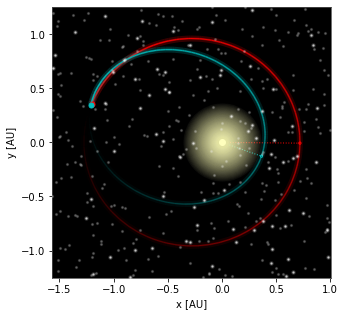

In [12]:
'''Conditions During Collision'''
sim = setupSimulation(mass,s1,s2,e1,e2)
sim.collision = "direct"
sim.collision_resolve = my_merge
sim.integrate(p2)